In [1]:

import pandas as pd
import numpy as np
import time
import datetime
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
plt.style.use('ggplot')


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import shap
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
np.set_printoptions(precision=4)

In [2]:
data = pd.read_csv('./flats_prepared.csv').drop('Unnamed: 0', axis = 1)
data.head()

,AD_ID,posted_date,posted_time,shown,price,currency,ptype,l_region,l_2,l_3,...,price/sizeM2,price/net_sizeM2,year_built,year_ren,condition,en_eff,switch,park_spots,balcony,garden
0,6523968,14.03.2021,18:49,57,192000,b'Euro',b'cumulative',b'Savinjska',b'Celje',b'SlavkoSlander',...,2232,1828,2004,0,b'nan',b'None',0,0,0,0
1,6523894,14.03.2021,18:39,29,134500,b'Euro',b'cumulative',b'Osrednjeslovenska',b'LjubljanaCenter',b'Center',...,4803,4637,1908,2020,b'Popolnoma opremljeno',b'EI',1,0,0,0
2,6523589,14.03.2021,18:07,33,29500,b'Euro',b'cumulative',b'Gorenjska',b'Trzic',b'Trzic',...,2681,2681,1961,0,b'nan',b'E',0,0,0,0
3,6523431,14.03.2021,17:47,34,120000,b'Euro',b'cumulative',b'Savinjska',b'SlovenskeKonjice',b'SlovenskeKonjice',...,0,1714,2020,0,b'Neopremljeno',b'A2',0,7,1,0
4,6523190,14.03.2021,17:16,23,180000,b'Euro',b'cumulative',b'Osrednjeslovenska',b'LjubljanaBezigrad',b'Bezigrad',...,3396,0,1988,0,b'nan',b'None',0,0,1,0


# Selecting features and values

In [3]:
ind = (data['sizeM2']<300) & (data['sizeM2']>0) & (data['price']>10000)&(data['year_built']>1800)
cols_drop = ['currency', 'AD_ID', 'posted_time', 'posted_date','shown', 'price/sizeM2', 'price/net_sizeM2', 'net_sizeM2', 'ptype']
data[ind].drop(columns = cols_drop).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 0 to 1187
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   price       792 non-null    int64 
 1   l_region    792 non-null    object
 2   l_2         792 non-null    object
 3   l_3         792 non-null    object
 4   sits_in     792 non-null    object
 5   lvl         792 non-null    object
 6   t_lvl       792 non-null    int64 
 7   flat_type   792 non-null    object
 8   sizeM2      792 non-null    int64 
 9   year_built  792 non-null    int64 
 10  year_ren    792 non-null    int64 
 11  condition   792 non-null    object
 12  en_eff      792 non-null    object
 13  switch      792 non-null    int64 
 14  park_spots  792 non-null    int64 
 15  balcony     792 non-null    int64 
 16  garden      792 non-null    int64 
dtypes: int64(9), object(8)
memory usage: 111.4+ KB


# Splitting Train and Test

In [4]:
train, test = train_test_split(data[ind].drop(columns = cols_drop), test_size=0.2, random_state = 42)

In [5]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 608 to 129
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   price       633 non-null    int64 
 1   l_region    633 non-null    object
 2   l_2         633 non-null    object
 3   l_3         633 non-null    object
 4   sits_in     633 non-null    object
 5   lvl         633 non-null    object
 6   t_lvl       633 non-null    int64 
 7   flat_type   633 non-null    object
 8   sizeM2      633 non-null    int64 
 9   year_built  633 non-null    int64 
 10  year_ren    633 non-null    int64 
 11  condition   633 non-null    object
 12  en_eff      633 non-null    object
 13  switch      633 non-null    int64 
 14  park_spots  633 non-null    int64 
 15  balcony     633 non-null    int64 
 16  garden      633 non-null    int64 
dtypes: int64(9), object(8)
memory usage: 89.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 1053 to 191
Data co

# Imputing categorical features

In [6]:
def impute_cats(df):
    # Find the columns of object type along with their column index
    object_cols = list(df.select_dtypes(exclude=[np.number]).columns)
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df.columns.get_loc(col))

    # Encode the categorical columns with numbers
    label_enc = LabelEncoder()
    encoders = {}
    
    
    for i in object_cols_ind:
        df.iloc[:,i] = label_enc.fit_transform(df.iloc[:,i])
        encoders[i] = label_enc
    return df

In [7]:
train_imp = impute_cats(train)
test_imp = impute_cats(test)

# Splitting into X and Y 

In [8]:
X_train = train_imp.drop('price', axis =1)
y_train = np.ravel(np.array(train_imp[['price']]))
X_test = test_imp.drop('price', axis =1)
y_test = np.ravel(np.array(test_imp[['price']]))

In [9]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(633, 16)

(633,)

(159, 16)

(159,)

# Defining RMSLE

In [10]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

# Fitting the models

## Random Forest

In [11]:
%%time
rf_model = RandomForestRegressor(#n_estimators=300,
                                      #max_depth=10,
                                      #min_samples_split=5,
                                      #min_samples_leaf=5,
                                      #max_features=None,
                                      random_state=42,
                                      #oob_score=True
                                     )
kf = KFold(n_splits=5)
y_pred_rf = cross_val_score(rf_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_rf.mean())
print(y_pred_rf)

0.7497943735946287
[0.7398 0.6719 0.7816 0.7187 0.8369]
Wall time: 2.85 s


In [12]:
%%time
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)

print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_rf)))

y_test_pred_rf = rf_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_rf)))

train RMSLE: 0.13143706657898208
test RMSLE: 0.6164746069231958
Wall time: 351 ms


<BarContainer object of 16 artists>

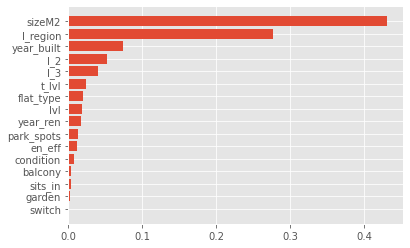

In [13]:
sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), rf_model.feature_importances_[sorted_idx])

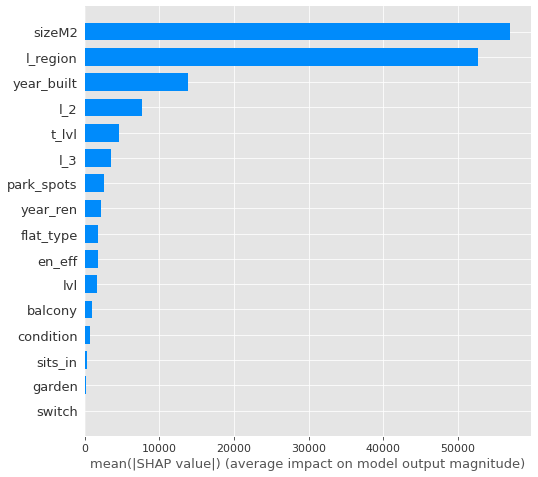

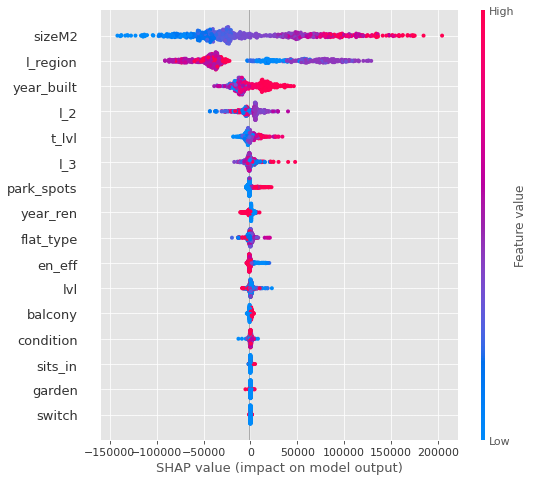

In [14]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Gradient boost Regressor GBM

In [15]:
%%time
gboost_model = GradientBoostingRegressor(#n_estimators=500, learning_rate=0.01,
                                     #max_depth=5, max_features='sqrt',
                                     #min_samples_leaf=15, min_samples_split=10,
                                     #loss='ls', random_state =42
                                   )


kf = KFold(n_splits=5)
y_pred_gboost = cross_val_score(gboost_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_gboost.mean())
print(y_pred_gboost)

0.7756894444227289
[0.7684 0.7046 0.7923 0.8058 0.8073]
Wall time: 1.46 s


In [16]:
%%time
gboost_model.fit(X_train, y_train)

y_train_pred_gboost = gboost_model.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_gboost)))

y_test_pred_gboost = gboost_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_gboost)))

train RMSLE: 0.1927637229209605
test RMSLE: 0.5624492078367492
Wall time: 123 ms


<BarContainer object of 16 artists>

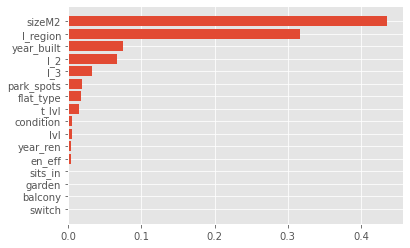

In [17]:
sorted_idx = gboost_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), gboost_model.feature_importances_[sorted_idx])

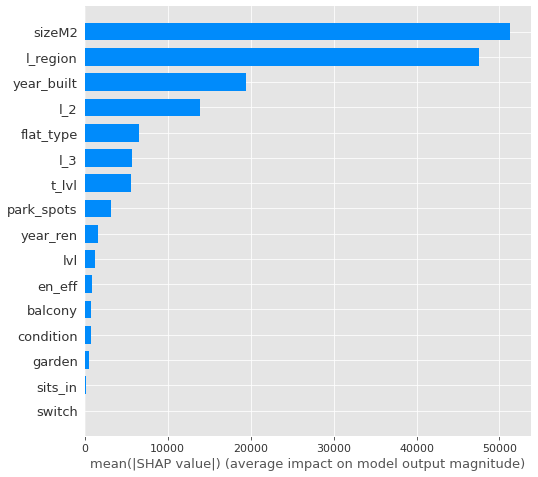

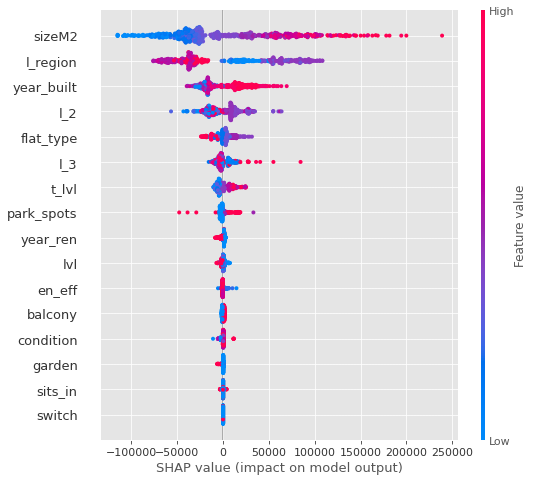

In [18]:
explainer = shap.TreeExplainer(gboost_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## XGBoost

In [19]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [20]:
%%time
xgboost_model = XGBRegressor(#learning_rate=0.01,
                         #n_estimators=1000,
                         #max_depth=4, min_child_weight=1,
                         #gamma=0.6, subsample=0.7,
                         #colsample_bytree=0.2,
                         #nthread=-1,
                         #scale_pos_weight=1, seed=27,
                         #reg_alpha=0.001
                       )

kf = KFold(n_splits=5)
y_pred_xgboost = cross_val_score(xgboost_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_xgboost.mean())
print(y_pred_xgboost)

0.7127156728568883
[0.6615 0.6655 0.7328 0.6517 0.8521]
Wall time: 567 ms


In [21]:
%%time
xgboost_model.fit(X_train, y_train)

y_train_pred_xgboost = xgboost_model.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_xgboost)))

y_test_pred_xgboost = xgboost_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_xgboost)))



train RMSLE: 0.00857665033384993
test RMSLE: 0.5812065508147671
Wall time: 231 ms


<BarContainer object of 16 artists>

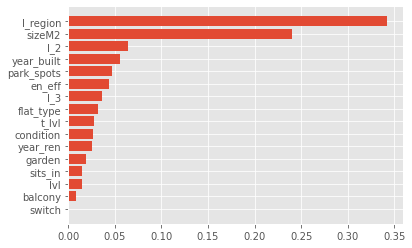

In [22]:
sorted_idx = xgboost_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), xgboost_model.feature_importances_[sorted_idx])


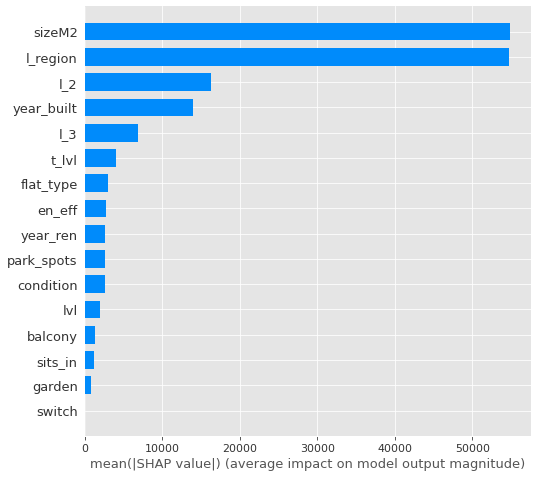

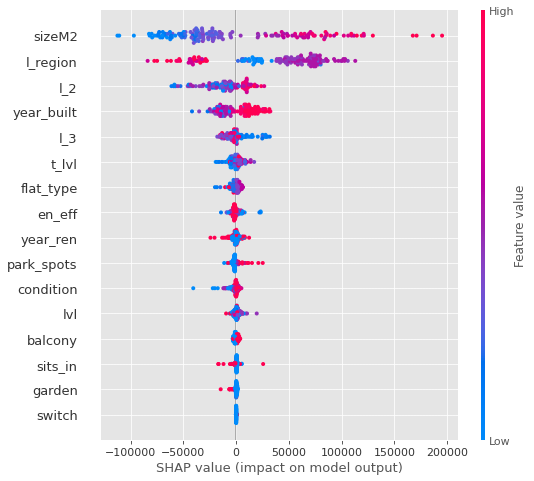

In [23]:
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

## LightGBM

In [24]:
%%time
lightgbm_model = LGBMRegressor(objective='regression', 
                                       #num_leaves=6,
                                       #learning_rate=0.01, 
                                       #n_estimators=5000,
                                       #verbose=-1,
                                       #bagging_fraction=0.80,
                                       #bagging_freq=4, 
                                       #bagging_seed=6,
                                       #feature_fraction=0.2,
                                       #feature_fraction_seed=7,
                                    )

kf = KFold(n_splits=5)
y_pred_lightgbm = cross_val_score(lightgbm_model, X_train, y_train, cv=kf)
print(y_pred_lightgbm.mean())
print(y_pred_lightgbm)

0.7575301385242245
[0.7548 0.6808 0.7308 0.7772 0.8441]
Wall time: 383 ms


In [25]:
%%time
lightgbm_model.fit(X_train, y_train)

y_train_pred_lightgbm = lightgbm_model.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_lightgbm)))

y_test_pred_lightgbm = lightgbm_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_lightgbm)))



train RMSLE: 0.1218512784915646
test RMSLE: 0.57663732628289
Wall time: 96.7 ms


<BarContainer object of 16 artists>

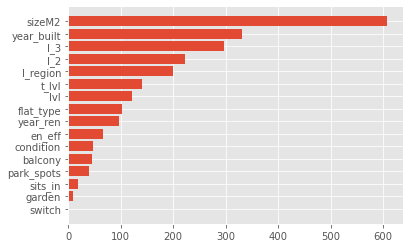

In [26]:
sorted_idx = lightgbm_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), lightgbm_model.feature_importances_[sorted_idx])

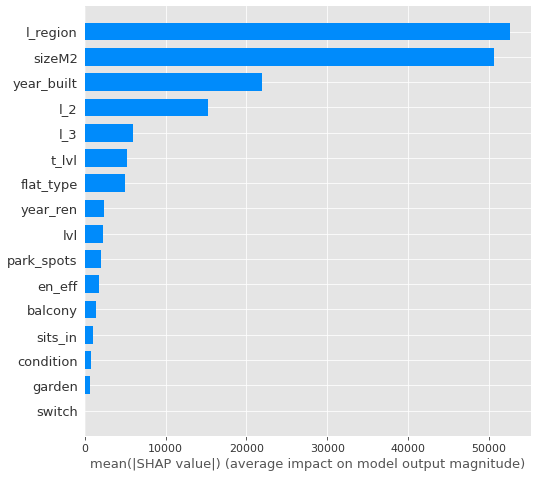

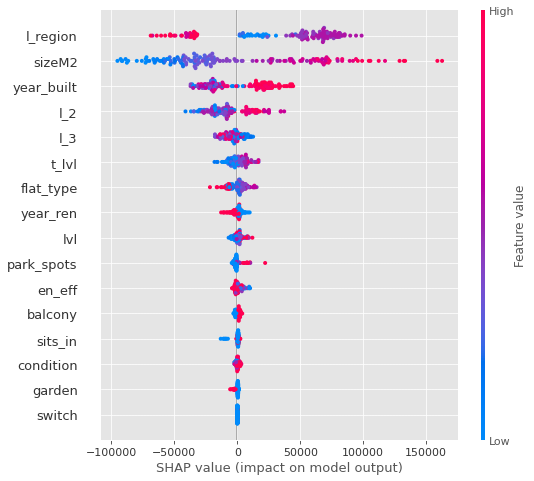

In [27]:
explainer = shap.TreeExplainer(lightgbm_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# Summary of the models

In [28]:
scores = [['RandomForest',y_pred_rf.mean(),rmsle(y_train, y_train_pred_rf), rmsle(y_test, y_test_pred_rf)],
          ['GBoostReg',y_pred_gboost.mean(),rmsle(y_train, y_train_pred_gboost), rmsle(y_test, y_test_pred_gboost)],
          ['XGBoost',y_pred_xgboost.mean(),rmsle(y_train, y_train_pred_xgboost), rmsle(y_test, y_test_pred_xgboost)],
          ['LightGBM',y_pred_lightgbm.mean(),rmsle(y_train, y_train_pred_lightgbm), rmsle(y_test, y_test_pred_lightgbm)]        
         ]

In [29]:
#scores before the optimization
scores_df = pd.DataFrame(scores, columns = ['Model_Name', 'y_pred', 'RMSLE_train', 'RMSLE_test'])
scores_df

,Model_Name,y_pred,RMSLE_train,RMSLE_test
0,RandomForest,0.749794,0.131437,0.616475
1,GBoostReg,0.775689,0.192764,0.562449
2,XGBoost,0.712716,0.008577,0.581207
3,LightGBM,0.757530,0.121851,0.576637


# Grid search parameter optimization

In [30]:
from sklearn.model_selection import GridSearchCV

## Random Forest

In [31]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [3,4,5,7,9],
    'max_features': [3,4,5,7,10],
    #'max_features': [int(x) for x in np.linspace(start = 3, stop = 10, num = 4)],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,200,300,500,700,1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [32]:
# Fit the grid search to the data
grid_search_rf.fit(X_train,y_train);

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 14.3min finished


In [33]:
rf_best = grid_search_rf.best_params_
rf_best

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 700}

## Evaluate the Best Model from Grid Search

In [34]:
rf_best = grid_search_rf.best_estimator_.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_train)

y_train_pred_rf_best = rf_best.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_rf_best)))

y_test_pred_rf_best = rf_best.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_rf_best)))

train RMSLE: 0.2040328747635724
test RMSLE: 0.5904139254735579


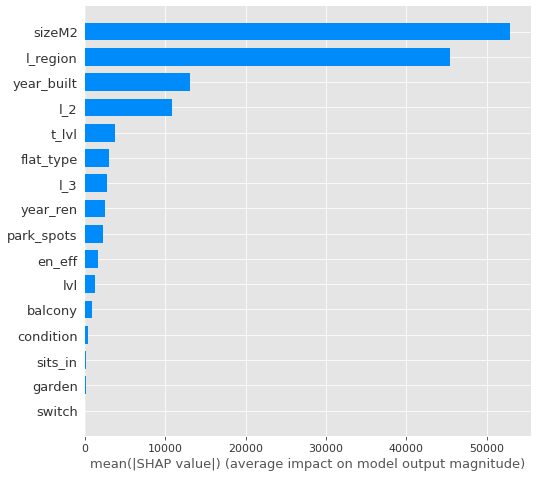

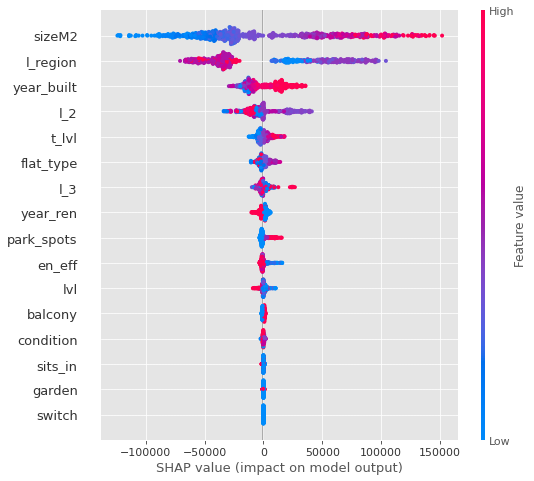

In [35]:
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Gradient Boost Regressor

In [36]:
#gboost_model = GradientBoostingRegressor(#n_estimators=500, learning_rate=0.01,
                                     #max_depth=5, max_features='sqrt',
                                     #min_samples_leaf=15, min_samples_split=10,
                                     #loss='ls', random_state =42
 #                                  )

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [3,4,5,7,9],
    'max_features': [5,7,10,15],
    'min_samples_leaf': [3,4,6,8],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': [100,200,300,500,700,1000]
}

# Create a base model
gboost_model = GradientBoostingRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_gboost = GridSearchCV(estimator = gboost_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [37]:
# Fit the grid search to the data
grid_search_gboost.fit(X_train,y_train);

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 525 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1173 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1618 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2145 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3441 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4210 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 5061 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  9.3min finished


In [38]:
gboost_best_par = grid_search_gboost.best_params_
gboost_best_par

{'max_depth': 4,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 700}

In [39]:
#Evaluation of the best model
gboost_best = grid_search_gboost.best_estimator_.fit(X_train, y_train)

y_train_pred_gboost_best = gboost_best.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_gboost_best)))

y_test_pred_gboost_best = gboost_best.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_gboost_best)))

train RMSLE: 0.027423717293458025
test RMSLE: 0.5556061460819242


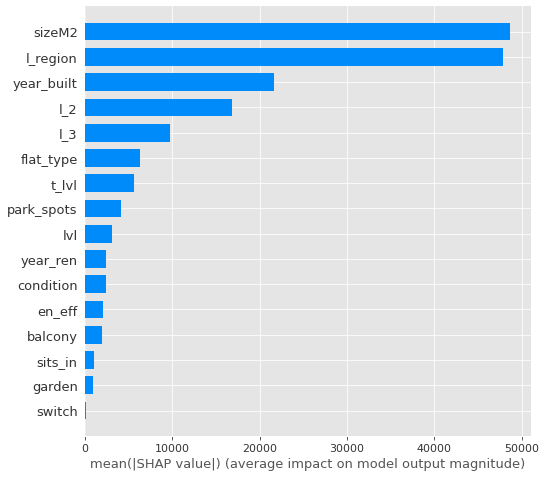

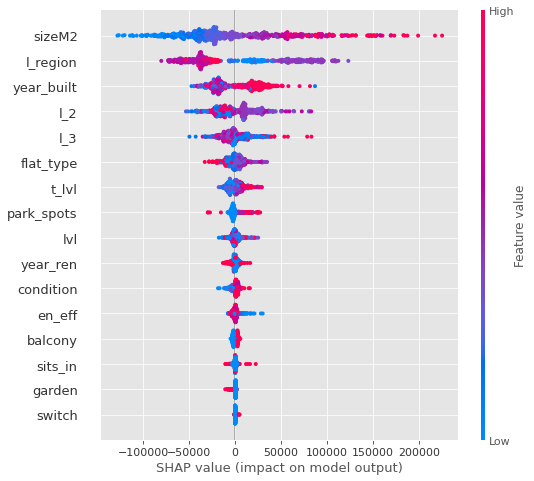

In [40]:
explainer = shap.TreeExplainer(gboost_best)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## XGBoost Regressor

In [41]:
#xgboost_model = XGBRegressor(#learning_rate=0.01,
                         #n_estimators=1000,
                         #max_depth=4, 
                         #min_child_weight=1,
                         #gamma=0.6, 
                         #subsample=0.7,
                         #colsample_bytree=0.2,
                         #nthread=-1,
                         #scale_pos_weight=1, 
                         #seed=27,
                         #reg_alpha=0.001)
                        
# https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde
                            
param_grid = {
    'learning_rate': [0.005, 0.010, 0.02, 0.05],
    #'min_child_weight':[1,2,3],
    #"gamma"        : [ 0.1, 0.2 , 0.3],
    "colsample_bytree" : [ 0.2, 0.3],
    'max_depth': [2,3,4, 5,],
    'max_features': [4,5],
    'n_estimators': [300, 500, 700, 1000]
}

# Create a base model
xgboost_model = XGBRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_xgboost = GridSearchCV(estimator = xgboost_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [42]:
# Fit the grid search to the data
grid_search_xgboost.fit(X_train,y_train);

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  2.9min finished


[21:02:49] WARNING: ..\src\learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [43]:
xgboost_best_par = grid_search_xgboost.best_params_
xgboost_best_par

{'colsample_bytree': 0.3,
 'learning_rate': 0.02,
 'max_depth': 4,
 'max_features': 4,
 'n_estimators': 1000}

In [44]:
#Evaluation of the best model
xgboost_best = grid_search_xgboost.best_estimator_.fit(X_train, y_train)
y_pred_xgboost_best = xgboost_best.predict(X_train)

y_train_pred_xgboost_best = xgboost_best.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_xgboost_best)))

y_test_pred_xgboost_best = xgboost_best.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_xgboost_best)))

[21:02:50] WARNING: ..\src\learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train RMSLE: 0.12258198416872816
test RMSLE: 0.517285748792987


In [45]:
y_test_pred_xgboost_best
y_test

array([170728.4  , 204142.5  , 222452.03 , 188797.83 , 283094.88 ,
       154054.84 ,  82856.195, 301041.56 , 172585.94 ,  62418.22 ,
       143829.17 , 148052.39 , 261565.3  ,  74334.914, 159994.84 ,
       168853.2  , 124535.75 , 110608.586, 272150.97 , 171667.23 ,
       263560.47 , 169493.17 , 129398.87 , 139692.61 , 108263.06 ,
       104429.71 , 199069.39 , 224326.7  , 245477.03 ,  58721.78 ,
       191787.89 , 111459.21 , 143391.17 , 227971.53 , 106610.2  ,
       188384.11 , 274152.06 , 236802.22 , 173388.11 , 116137.93 ,
       191122.52 , 258117.97 , 166922.6  , 255810.75 , 135702.1  ,
       289995.53 , 235027.78 , 149781.83 , 145598.86 , 240799.89 ,
       202446.05 , 173984.19 ,  93722.22 , 130853.61 , 142854.1  ,
       162140.36 , 368411.84 , 109989.37 , 158708.11 , 193000.12 ,
       260163.81 ,  85728.44 , 122912.54 , 133669.72 , 365481.5  ,
        99408.44 , 242372.53 , 263093.88 , 107150.32 , 140844.84 ,
       156023.08 , 258255.94 , 170164.98 ,  78414.93 , 119416.

array([ 310000,  298000,  159900,  455000,  243000,   99000,   48000,
        429000,   67000,   64900,  179000,  122229,  150000,   90000,
        150000,  139900,  109990,   70500,  184000,  188000, 1300000,
        280000,   90000,  210000,  165000,  120000,  125914,  169000,
        126000,   58000,  225000,  159000,  225000,  600000,  120000,
        156119,  210000,  139900,  129000,  105000,  120439,  147000,
         98539,  109870,  315000,  150000,  255500,  225000,  145002,
        370000,  131500,  152713,   67000,  128461,   48000,  189000,
        289726,  127000,   75000,   65000,  495000,   76000,   75595,
         99990,  413680,  115517,  141244,  245000,   55000,  129999,
        118000,  130000,  149000,   63000,  110000,  193000,  332125,
        116059,  116157,   33450,  120000,  258000,   76000,  109000,
        139803,   58000,   84400,  430000,   90100,  140000,  223932,
        775700,  346653,  138000,  104906,  120000,   80000,  105956,
        149000,  110

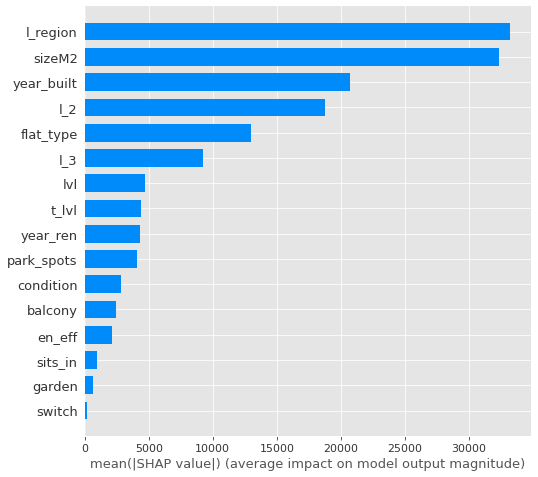

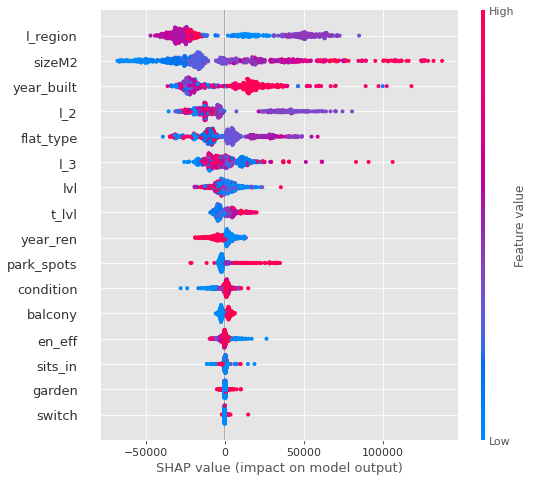

In [46]:
explainer = shap.TreeExplainer(xgboost_best)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## LightGBM

In [47]:
%%time
#lightgbm_model = LGBMRegressor(objective='regression', 
                                       #num_leaves=6,
                                       #learning_rate=0.01, 
                                       #n_estimators=5000,
                                       #verbose=-1,
                                       #bagging_fraction=0.80,
                                       #bagging_freq=4, 
                                       #bagging_seed=6,
                                       #feature_fraction=0.2,
                                       #feature_fraction_seed=7)
                                    

param_grid = {
       'num_leaves' :[3,4,5,7],
       'learning_rate':[0.01, 0.02, 0.03], 
       #'bagging_fraction'=0.80,
       #'bagging_freq'=4, 
       #'bagging_seed'=6,
       #'feature_fraction'=0.2,
       #'feature_fraction_seed'=7,
        'max_depth': [3, 5, 7],
        #'max_features': [4,6,8,10],
        'n_estimators':[100, 300, 500, 1000],
        'num_iterations' : [100, 200]
}

# Create a base model
lightgbm_model = LGBMRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_lightgbm = GridSearchCV(estimator = lightgbm_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

Wall time: 0 ns


In [48]:
# Fit the grid search to the data
grid_search_lightgbm.fit(X_train,y_train);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:   32.9s finished
Found `num_iterations` in params. Will use it instead of argument


In [49]:
lightgbm_best_par = grid_search_lightgbm.best_params_
lightgbm_best_par

{'learning_rate': 0.03,
 'max_depth': 7,
 'n_estimators': 100,
 'num_iterations': 200,
 'num_leaves': 7}

In [50]:
#Evaluation of the best model
lightgbm_best = grid_search_lightgbm.best_estimator_.fit(X_train, y_train)
y_pred_lightgbm_best = lightgbm_best.predict(X_train)

y_train_pred_lightgbm_best = lightgbm_best.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_lightgbm_best)))

y_test_pred_lightgbm_best = lightgbm_best.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_lightgbm_best)))

train RMSLE: 0.24508780012668116
test RMSLE: 0.5585405868175907


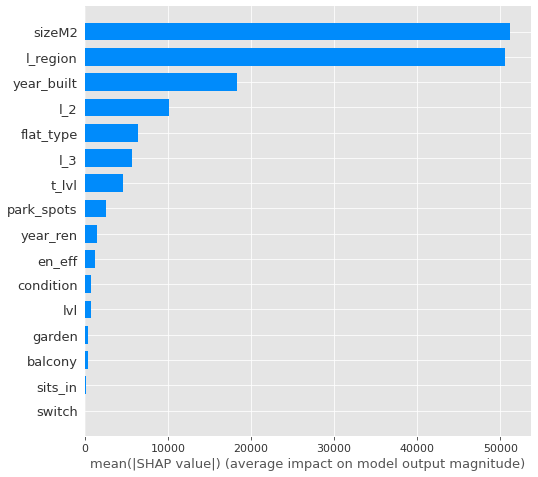

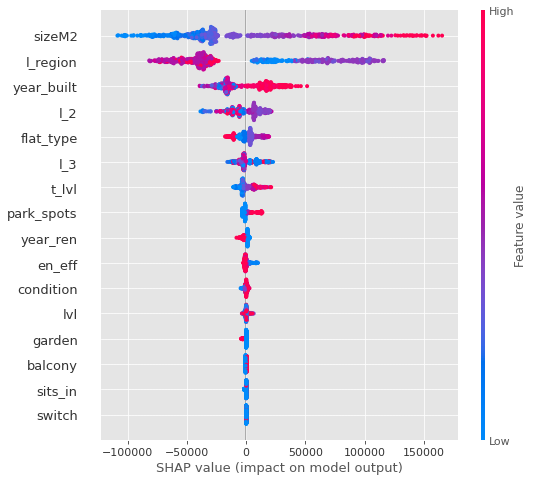

In [51]:
explainer = shap.TreeExplainer(lightgbm_best)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

# Aggregating results

In [52]:
scores_best = [['RandomForest_best',rmsle(y_train, y_train_pred_rf_best), rmsle(y_test, y_test_pred_rf_best)],
          ['GBoostReg_best',rmsle(y_train, y_train_pred_gboost_best), rmsle(y_test, y_test_pred_gboost_best)],
          ['XGBoost_best',rmsle(y_train, y_train_pred_xgboost_best), rmsle(y_test, y_test_pred_xgboost_best)],
          ['LightGBM_best',rmsle(y_train, y_train_pred_lightgbm_best), rmsle(y_test, y_test_pred_lightgbm_best)]        
         ]



In [53]:
#scores before the optimization
scores_best_df = pd.DataFrame(scores_best, columns = ['Model_Name', 'RMSLE_train', 'RMSLE_test'])
scores_best_df

,Model_Name,RMSLE_train,RMSLE_test
0,RandomForest_best,0.204033,0.590414
1,GBoostReg_best,0.027424,0.555606
2,XGBoost_best,0.122582,0.517286
3,LightGBM_best,0.245088,0.558541


In [54]:
scores_df

,Model_Name,y_pred,RMSLE_train,RMSLE_test
0,RandomForest,0.749794,0.131437,0.616475
1,GBoostReg,0.775689,0.192764,0.562449
2,XGBoost,0.712716,0.008577,0.581207
3,LightGBM,0.757530,0.121851,0.576637


# Stacking

Stacking part was adapted from the regression part of the MLmastery article found here:
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

In [55]:

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
from numpy import mean
from numpy import std

In [56]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('rf', RandomForestRegressor()))
    level0.append(('gboost', GradientBoostingRegressor()))
    level0.append(('xgboost', XGBRegressor()))
    level0.append(('lightgbm', LGBMRegressor()))
    # define meta learner model
    level1 = RandomForestRegressor()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [57]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['rf'] = RandomForestRegressor()
    models['gboost'] = GradientBoostingRegressor()
    models['xgboost'] = XGBRegressor()
    models['lightgbm'] = LGBMRegressor()
    models['stacking'] = get_stacking()
    return models

In [58]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [59]:
# define dataset
X, y = X_train, y_train

In [60]:
# get the models to evaluate
models = get_models()

In [61]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s  ddd%.3f (%.3f)' % (name, mean(scores), std(scores)))

>rf  ddd-59705.529 (11570.077)
>gboost  ddd-56343.737 (11590.559)
>xgboost  ddd-60430.944 (12272.234)
>lightgbm  ddd-60357.017 (13328.557)
>stacking  ddd-61483.861 (13846.088)


{'whiskers': [<matplotlib.lines.Line2D at 0x26164769b50>,
 'caps': [<matplotlib.lines.Line2D at 0x26164783250>,
 'boxes': [<matplotlib.lines.Line2D at 0x26164769850>,
 'medians': [<matplotlib.lines.Line2D at 0x261647838e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x26164783f40>,
 'means': [<matplotlib.lines.Line2D at 0x26164783c10>,
  <matplotlib.lines.Line2D at 0x26164bc63d0>]}

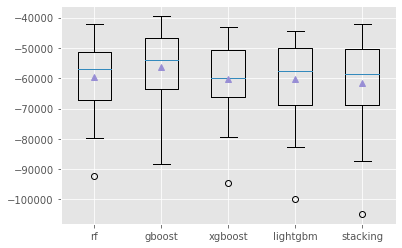

In [63]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
#pyplot.show()